In [1]:
import models
import functions
from data_utils import load_cifar
import matplotlib.pyplot as plt
import optimization
import os
import optimization 

In [2]:
notebook_path = os.path.dirname(os.path.abspath("__file__"))
filename = notebook_path + "/CNNmodel.pt"

In [3]:
device = "cpu"
X, y = load_cifar(device)

X = X.reshape(-1, 3, 32, 32)
# One-hot encode the labels and normalize the pixel intensities to [-1, 1]
yhot = functions.one_hot_encode(y, 10)
Xnorm = 2*(X/255 - 1/2)

X_train, y_train = Xnorm[:50000], yhot[:50000]
X_val, y_val = Xnorm[50000:], yhot[50000:]

In [4]:
cnn = models.CNN((32, 32), 3, device=device)

In [5]:
adam_opt = optimization.Optimizer_Adam()
trainer =  optimization.Trainer(adam_opt, save_path = filename)
batch_size = 100
epochs = 30

In [7]:
trainer.train(cnn, X_train, y_train, batch_size, epochs, X_val=X_val, y_val=y_val)

[Epoch: 1, batch: 1]/500                         loss: 0.051
[Epoch: 1, batch: 101]/500                         loss: 2.249
[Epoch: 1, batch: 201]/500                         loss: 1.971
[Epoch: 1, batch: 301]/500                         loss: 1.872
[Epoch: 1, batch: 401]/500                         loss: 1.779
[Epoch: 1, test accuracy: 0.431, validation accuracy: 0.425
Best accuracy: 0.425
[Epoch: 2, batch: 1]/500                         loss: 0.015
[Epoch: 2, batch: 101]/500                         loss: 1.581
[Epoch: 2, batch: 201]/500                         loss: 1.557
[Epoch: 2, batch: 301]/500                         loss: 1.520
[Epoch: 2, batch: 401]/500                         loss: 1.476
[Epoch: 2, test accuracy: 0.506, validation accuracy: 0.495
Best accuracy: 0.495
[Epoch: 3, batch: 1]/500                         loss: 0.013
[Epoch: 3, batch: 101]/500                         loss: 1.423
[Epoch: 3, batch: 201]/500                         loss: 1.376
[Epoch: 3, batch: 301]/50

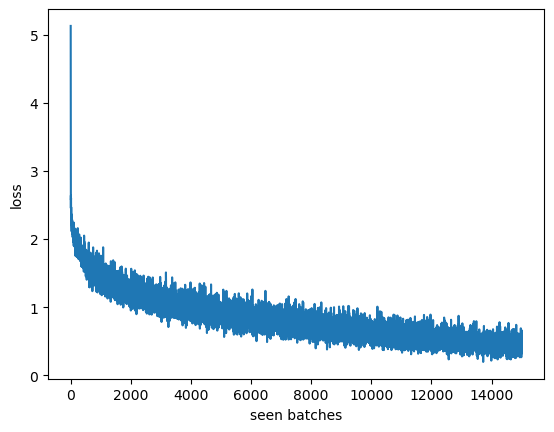

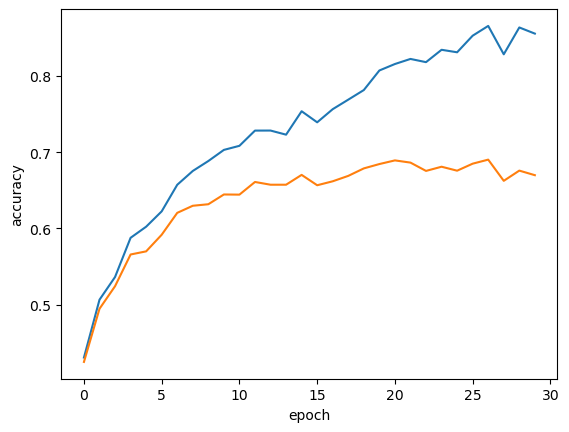

In [8]:
trainer.plot()

# Appendix 1: how to compute zero padding with general stride and kernel size

In my implementation of the convolutional layer, we including the 'same' padding scheme, which picks 
the minimal amount of padding to make the final image have size $\lceil h/s_h \rceil /times \lceil w/s_w \rceil $.
Below I include a small derivation on how to pick the padding.

Consider an input image of height $h_0$. We now want to run a convolution on the image with a kernel 
of height $k$ and a stride of $s$ along the height-axis. Our goal is now to compute the correct amount 
of padding $p$ that we need in the height direction. 

First, consider an input image of size $h$, which we will eventually take to be $h=h_0 + p$. But keep 
it general for now, and consider doing the convolution on an image of this height, with no padding. 
The $i$-th row of the output image is sensitive to pixels in the range
$$[i s, is + k -1 ]$$
of indices in the input image. Thus, the maximal $i$ in the output image is the maximal $i_{\rm max}$ such that
$$i_{\rm max}s+ k -1 \leq h-1$$
The solution is 
$i_{\rm max} = \lfloor (h-k)/s \rfloor$. 
Consequently, the output height is $h_{\rm out} = \lfloor (h-k)/s \rfloor+1$. To use same padding, we 
now need to set $h=h_0 + p$ and solve for $p$ such that $h_{\rm out}=\lceil h_0/2\rceil$. The last condition
is simply the definition of the 'same' padding scheme. Thus, we have the equation
$$ \lceil h_0/2\rceil = \lfloor \frac{h_0 + p-k}{s} \rfloor  + 1$$
To solve this equation, which we call the "padding equation", note first that
$$ p_* = \left(\lceil h_0/s\rceil -1 \right)s + k - h_0$$
is a solution. This can be verified by insertion. Now, this is not the unique solution of the equation,
but it is in fact the smallest solution. To show this, assume for contradiction that $\hat{p} = p_* - |\Delta|$ 
is a solution for some $\Delta$. Plugging it in we see that this reduces to
$$ 0 = \lfloor -|\Delta| \rfloor < 0$$
One the other hand, setting,
$$ \hat{p} = p_* + |\Delta| $$
we do get new solutions as long as $|\Delta| < s$ (readily checked by insertion). Now, which solution should we use? If $p_*$ is positive,
then this is the optimal solution - i.e. the smallest padding. If $p_*$ is negative, then we should keep adding one until
we reach a non-negative value, and then stop. This is of course leads us to stopping at $p=0$. There is one one caveat though: 
we are only allows to add $+1$ to $p_*$ less than $s$ times, otherwise we no longer have a solution of the "padding equation".
Thus, we should be able prove that $p_* > -s$, since clearly that padding equation ought to have some solution. 
Let us now do this. There always exists integers $N, \delta$ with $0\leq \delta< s$ such that
$$ h_0 = Ns + \delta $$
In this form, we can lower bound the solution $p_*$. Pluggin in this form of $h_0$ we get 
$$ p_* = Ns + k - (Ns + \delta) = k - \delta > - \delta > - s$$
Thus, if $p_*<0$, then $p=0$ is always a solution to the "padding equation", and we finally conclude that
$$ 
p = \max(0 , p_*) 
$$

# Appendix 2: how do do the 2d convolution in practice with Tensors

Consider a CNN layer.
Let $z^{k}_{ij}$ be the $(i,j)$ pixel of the $k$ th feature map of the output of this layer. Let the same notation with
$z \rightarrow s$ denote the input. 
Focusing on the rows (the height dimension of the image), the indices in the previous layer that $z^{k}_{ij}$ is sensitive to is
$$ [is_h, is_h+k_h-1] $$
where $s_h$ is the stride and $k_h$ the filter/kernel size along the row/height dimension. Analogously $s_w, k_w$ are the stride and kernel
size in the width/column direction.

 Let now $W^{kk'}_{hw}$ for $h = 0, \ldots k_h-1$ and $w = 0, \ldots, k_h -1$ be the weights for the convolution -- the convolutional kernel. 
 The equation for the convolution then is
 $$ z^{k}_{ij} = b^k + \sum_{h, w = 0}^{k_h-1, k_w -1}\sum_{k'} W^{kk'}_{hw} s^{k'}_{(is_h+h)(js_w +w)}$$

A convenient way to do this is to define a projector $P_{ij hw i' j}$ such that 
$$ Z_{hw ij}^{k'} \equiv z^{(\ell-1)k'}_{(i s_h + h)(js_w + w)} = P_{hw ij mn } z_{mn}^{k'} $$
where the implicit sums over $mn$ now run over the full range of the input image, ie $m=0,\ldots, H-1, n=0, \ldots, W-1$ and 
$H,W$ is the height and width of the input image.
We see that this projector simply is 
$$ P_{hw ij mn } = \theta(m \in [is_h, is_h + k_h - 1])\theta(n \in [is_h, is_h + k_h - 1])$$